# Excitation only - EPSPs 

Here we set the figures for the cases with only excitation in spines.

In [1]:
import numpy as np
from numpy.random import exponential, randint
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True


import PS_lib as lb
import PS_storage as st

## Setting up the model

### Topology of the neuron

We set first a simplistic neuron

In [2]:
# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.1
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("Basic2.hoc",axon=False)
# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5)
model.addSpne(locus="DendE",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
data.model = model.__dict__
# Temperature of the neuron
lb.h.celsius = model.temperature
print("Topology:")
print(lb.h.topology())

	0 
	1 
	1 
	1 
	1 
Topology:

|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
      `|       DendE(0-1)
       `|       NSpne000(0-1)
         `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Recording places

We set recording vectors in all dendritic compartments, spine included

In [3]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)


Vector[11]

In [10]:
rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2
gtrG = 30e-6*2/5.0
gtrA = 11e-6*2/5.0
gtrN = 30e-6/16.0


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [5]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.5
tau2 = 8.0
AMPA.tau1 = tau1
AMPA.tau2 = tau2

nampa = 50
gmax = 11*nampa/1e6
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = 50*nnmda/1e6
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN


In [7]:
NMDA.tau1 = 2.0
NMDA.tau2 = 30.0

In [8]:
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = 3
dend.diam = 1.5
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dend.diam = 0.7
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-1]
dend.diam = 0.5
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

3.0 1.5
200.24984394500785 0.6999999880790709 4.244131815783876
4.0 0.5 654.6676747288462
The resistance of neck and the dendritic impedance are 141.47 and 680 MΩ (resp.)


## Plots

xkcd is to give it non serious appearance

In [9]:
xkcd()

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt


(40, 100)

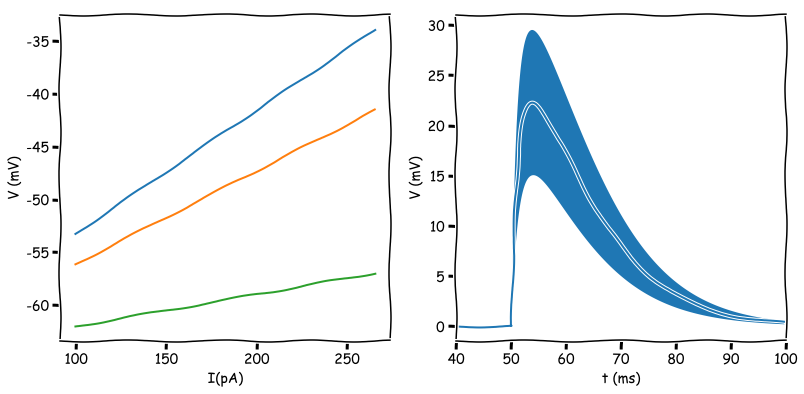

In [15]:
dend.Ra = 250
neck.Ra = 250
model.E_PAS = -65
model.soma.e_pas = -65
for dendp in model.dend:
    dendp.e_pas = -65
for sp in model.spne:
    sp.e_pas = -65
    

ton = 50

toffset = 50

tG = ton+10


gA1ampa = 11/1e6

t_stop = 250
vavg = zeros((int(t_stop/lb.h.dt+1),7))
vtracs = zeros((int(t_stop/lb.h.dt+1),500))
Ctracs = zeros((int(t_stop/lb.h.dt+1),500))
vtracsD = zeros((int(t_stop/lb.h.dt+1),500))

nampas = array([100,200,300,400])
mes = zeros((nampas.shape[0],5))
vavg = zeros((int(t_stop/lb.h.dt+1),7))
for i,nampa in enumerate(nampas):
    #lb.add_somaStim(model,p=0.5,onset=ton,dur=2, amp =0.0)
    NC.delay = ton-50
    NCN.delay = ton-50
    NC.weight[0] = nampa  *gtrA#/2
    NCN.weight[0] =0 *gtrN*0#*0
    # ~ print(NC.weight[0])
    lb.h.finitialize(model.E_PAS)
    # ~ print(NC.weight[0])
    
    lb.neuron.run(t_stop)
    
    #plot(trec,vspneRec[0])    
    
    current = abs((array(vDendRec[-2])-array(vDendRec[0]))/Rdend)
    
    vavg[:,0] += array(vspneRec[0]) 
    vavg[:,1] += array(vspneRec[0])**2
    vavg[:,2] += array(vDendRec[0]) 
    vavg[:,3] += array(vDendRec[0])**2
    vavg[:,4] += array(vrec) 
    vavg[:,5] += array(vrec)**2
    vavg[:,6] += 1
        
    mes[i,:] = [nampa,max(vspneRec[0]),max(vDendRec[1]),max(vrec),max(current)]

vavg[:,:5] = vavg[:,:5]/vavg[0,6]
vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])

fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)
    
plot(mes[:,-1]/1e-12,mes[:,1],label="Spine head")
plot(mes[:,-1]/1e-12,mes[:,2],label="Dendritic shaft")
plot(mes[:,-1]/1e-12,mes[:,3],label="Soma")

xlabel("I(pA)")
ylabel("V (mV)")

ax = fig.add_subplot(122)
vavt = vavg[:,:2]*1.0
vavt[:,0] = vavg[:,0]-vavg[0,0] 
plot(trec,vavt[:,0]-vavt[0,0],label="Spine head")
fill_between(trec,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1])
xlabel("t (ms)")
ylabel("V (mV)")
xlim(40,100)


In [16]:
model.__dict__

{'CM': 1.0,
 'RM': 7000.0,
 'RA': 250.0,
 'E_PAS': -65,
 'temperature': 37,
 'Ek': -90,
 'Ena': 60,
 'Eca': 140,
 'gna_axon': 1000,
 'gkv_axon': 100,
 'gna_soma': 1000,
 'gkv_soma': 100,
 'gkm_soma': 2.2,
 'gkca_soma': 3,
 'gca_soma': 0.5,
 'git_soma': 0.0003,
 'gna_dend': 80,
 'gkv_dend': 3,
 'gkm_dend': 1,
 'gkca_dend': 3,
 'gca_dend': 0.5,
 'git_dend': 0.00015,
 'gh_dend': 0,
 'soma': soma,
 'dend': [dendA1c, dendA1, dendB1, DendE],
 'spne': [Spne000],
 'neck': [NSpne000],
 'AMPAlist': [Exp2Syn[0]],
 'ncAMPAlist': [NetCon[0]],
 'NMDAlist': [Exp2SynNMDA[0]],
 'ncNMDAlist': [NetCon[2]]}

In [17]:
vaF = {}
meF = {}

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt


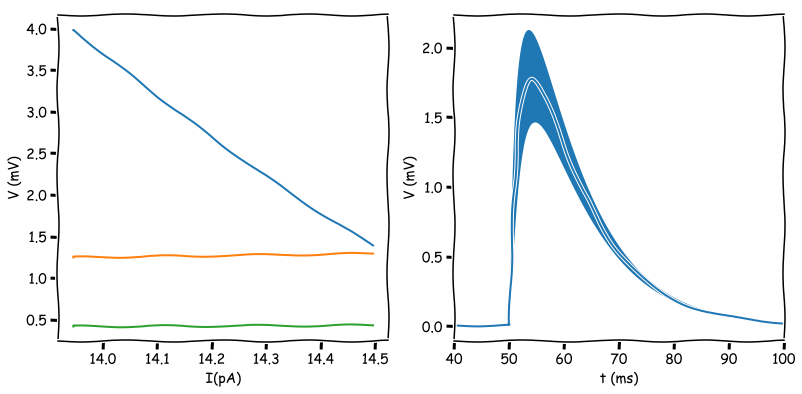

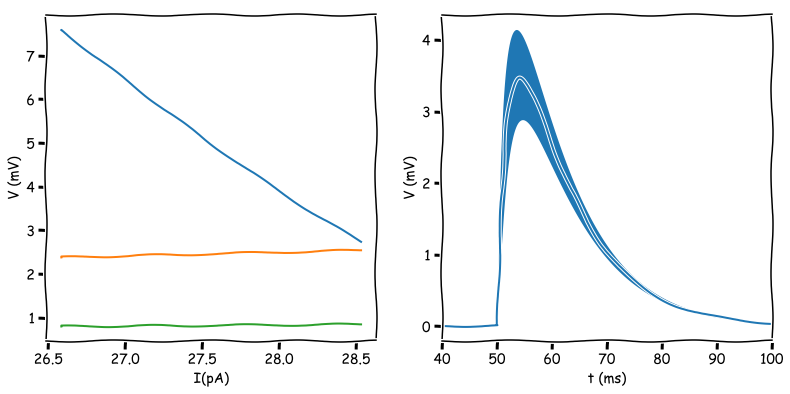

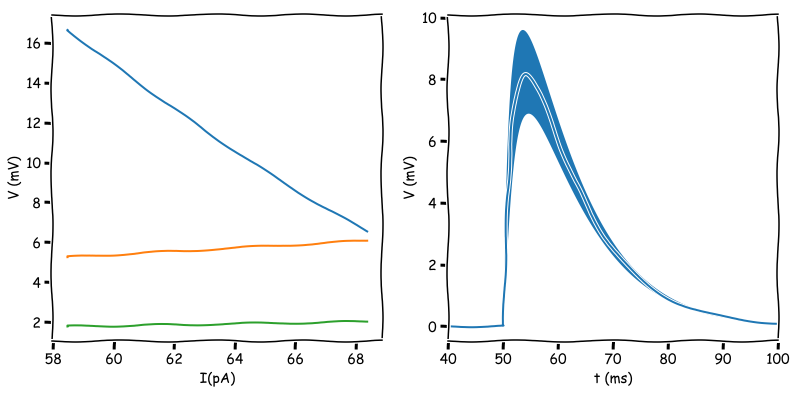

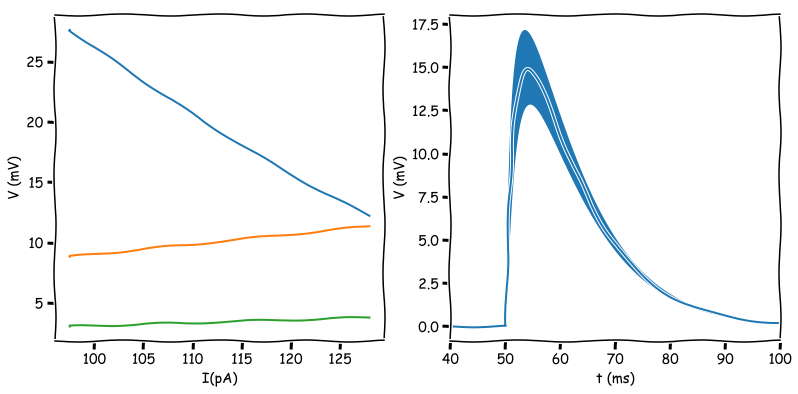

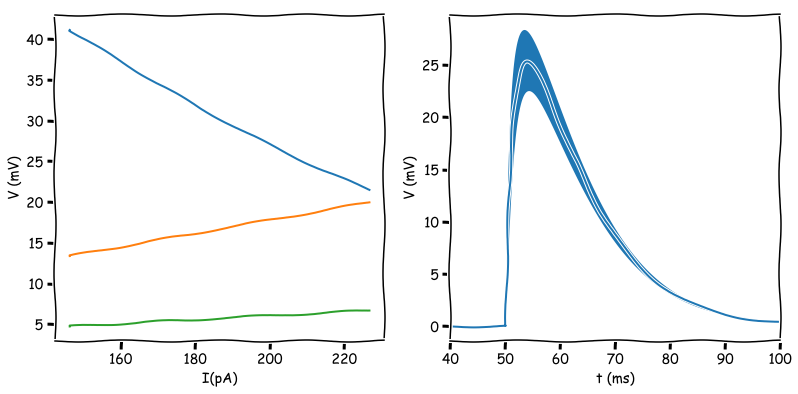

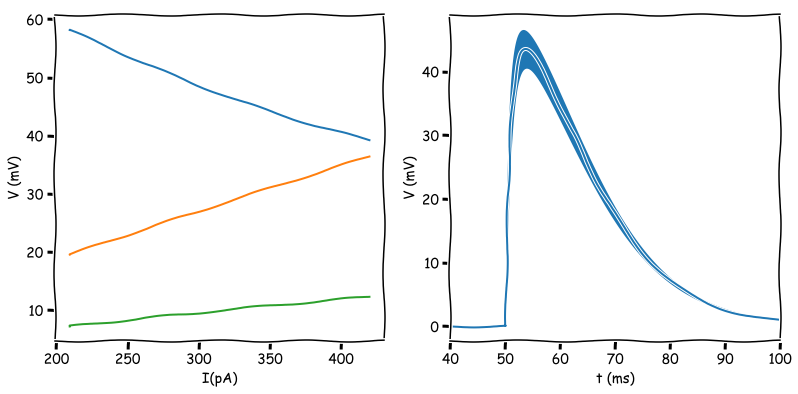

In [18]:
dend.Ra = 250
neck.Ra = 250
model.E_PAS = -80
model.soma.e_pas = -80
for dendp in model.dend:
    dendp.e_pas = -80
for sp in model.spne:
    sp.e_pas = -80

nampas = [10,20,50,100,200,500]
Ranecks = 250*exp(randn(500)*0.7+0.0)

for nampa in nampas:
    ton = 50
    t_stop = 200
    #nampa = 20
    mes = zeros((Ranecks.shape[0],6))
    vavg = zeros((int(t_stop/lb.h.dt+1),9))
    for i,Ra in enumerate(Ranecks):
        #lb.add_somaStim(model,p=0.5,onset=ton,dur=2, amp =0.0)
        NC.delay = ton-50
        NCN.delay = ton-50
        NC.weight[0] = nampa  *gtrA#/2
        NCN.weight[0] =0 *gtrN*0#*0
        neck.Ra = Ra
        #neck.Ra = 250
        #neck.L = Ra/250 
        neck.L = 1.0
        Rneckt = Rneck*Ra/250

        # ~ print(NC.weight[0])
        lb.h.finitialize(model.E_PAS)
        # ~ print(NC.weight[0])

        lb.neuron.run(t_stop)

        #plot(trec,vspneRec[0])    

        current = (array(vDendRec[-2])-array(vDendRec[0]))/Rdend

        #vavg[:,0] += array(vspneRec[0]) 
        #vavg[:,1] += array(vspneRec[0])**2
        #vavg[:,2] += array(vDendRec[0]) 
        #vavg[:,3] += array(vDendRec[0])**2
        #vavg[:,4] += array(vrec) 
        #vavg[:,5] += array(vrec)**2
        #vavg[:,6] += 1



        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[0]) 
        vavg[:,3] += array(vDendRec[0])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += current 
        vavg[:,7] += current**2
        vavg[:,-1] += 1
        current = abs(current)

        mes[i,:] = [Rneckt,max(vspneRec[0]),max(vDendRec[1]),max(vrec),max(current),nampa]

    vavg[:,:-1] = vavg[:,:-1]/vavg[0,-1]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])

    fig = figure(figsize=(13,6))
    ax = fig.add_subplot(121)

    ImaxnA = 1# (NC.weight[0]/area/model.CM*1e6)

    sel = mes[:,0].argsort()
    plot(mes[sel,-2]/1e-12/ImaxnA,mes[sel,1]-vavg[0,0],label="Spine head")
    plot(mes[sel,-2]/1e-12/ImaxnA,mes[sel,2]-vavg[0,0],label="Dendritic shaft")
    plot(mes[sel,-2]/1e-12/ImaxnA,mes[sel,3]-vavg[0,0],label="Soma")

    #xlabel("I(pA)/I_max")
    xlabel("I(pA)")

    ylabel("V (mV)")

    ax = fig.add_subplot(122)
    vavt = vavg[:,:2]*1.0
    vavt[:,0] = vavg[:,0]-vavg[0,0] 
    plot(trec,vavt[:,0]-vavt[0,0],label="Spine head")
    fill_between(trec,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1])
    xlabel("t (ms)")
    ylabel("V (mV)")
    xlim(40,100)

    vaF[nampa] = vavg*1.0
    meF[nampa] = mes*1.0
    savefig("FigE_NAMPA"+str(nampa).zfill(3)+".pdf")

Text(0.5, 0, '$R_{neck}$')

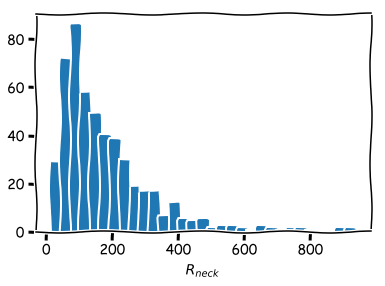

In [19]:
figure()
hist(mes[:,0]/1e6,31)
xlabel("$R_{neck}$")

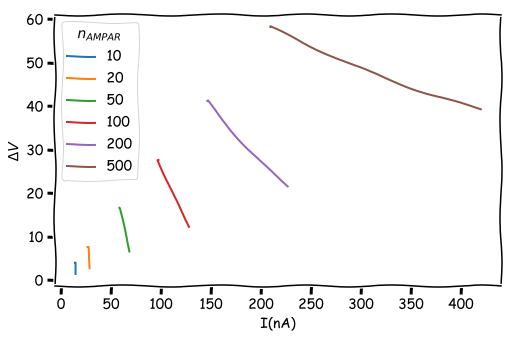

In [20]:
figure(figsize=(8,5))
for key in meF.keys():
    mes = 1.0*meF[key]
    sel = mes[:,0].argsort()
    plot(mes[sel,-2]/1e-12,mes[sel,1]-vavg[0,0],label=int(mes[0,-1]))
xlabel("I(nA)")
ylabel("$\Delta V$")
legend(title="$n_{AMPAR}$")

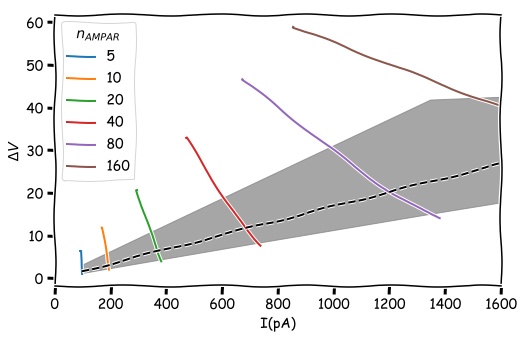

In [137]:
data = zeros((len(meF.keys()),6))
figure(figsize=(8,5))
for i,key in enumerate(meF.keys()):
    vavg = 1.0*vaF[key]
    vavt = vavg[:,:2]*1.0
    vavt[:,0] = vavg[:,0]-vavg[0,0] 
    data[i,:3] = [max(vavt[:,0]),max(vavt[:,0]+vavt[:,1]),max(vavt[:,0]-vavt[:,1])]
    vavt = abs(vavg[:,-3:-1])
    data[i,3:] = [max(vavt[:,0]),max(vavt[:,0]+vavt[:,1]),max(vavt[:,0]-vavt[:,1])]
    mes = 1.0*meF[key]
    sel = mes[:,0].argsort()
    l = len(mes[:,0])
    me,q1,q2 = (mean(log(mes[:,1]-vavg[0,0])),log(mes[sel[l*5//100],1]-vavg[0,0]),log(mes[sel[l*95//100],1]-vavg[0,0]))
    data[i,:3] = [exp(me),exp(q1),exp(q2)]
    me,q1,q2 = (mean(log(mes[:,-2]*1e12)),log(mes[sel[l*5//100],-2]*1e12),log(mes[sel[l*95//100],-2]*1e12))
    data[i,3:] = [exp(me),exp(q1),exp(q2)]
    
    plot(mes[sel,-2]/1e-12,mes[sel,1]-vavg[0,0],label=int(mes[0,-1]))
    
plot(data[:,3],data[:,0],'k--')
#plot(data[:,5],data[:,2],'k--')
#plot(data[:,4],data[:,1],'k--')

xlim(0,1600)
fill_between(data[:,4],interp(data[:,4],data[:,5],data[:,2]),data[:,1],color='gray',alpha=0.7)
xlabel("I(pA)")
ylabel("$\Delta V$")
legend(title="$n_{AMPAR}$")

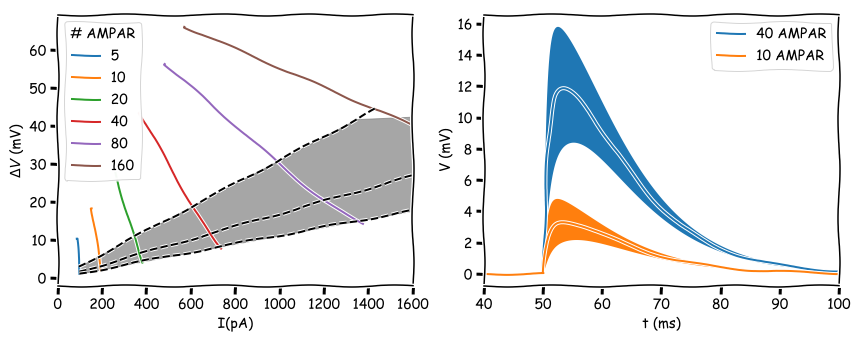

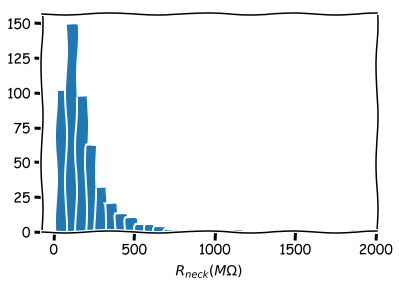

In [154]:
fig = figure(figsize=(14,5))

ax = fig.add_subplot(121)
for i,key in enumerate(meF.keys()):
    mes = 1.0*meF[key]
    sel = mes[:,0].argsort()
    plot(mes[sel,-2]/1e-12,mes[sel,1]-vavg[0,0],label=int(mes[0,-1]))
    
plot(data[:,3],data[:,0],'k--')
plot(data[:,5],data[:,2],'k--')
plot(data[:,4],data[:,1],'k--')

xlim(0,1600)
fill_between(data[:,4],interp(data[:,4],data[:,5],data[:,2]),data[:,1],color='gray',alpha=0.7)
xlabel("I(pA)")
ylabel("$\Delta V$ (mV)")
legend(title="# AMPAR")


ax = fig.add_subplot(122)
vavg = vaF[40.0]
vavt = vavg[:,:2]*1.0
vavt[:,0] = vavg[:,0]-vavg[0,0] 
plot(trec,vavt[:,0]-vavt[0,0],label="40 AMPAR")
fill_between(trec,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1])
xlabel("t (ms)")
ylabel("V (mV)")
xlim(40,100)

vavg = vaF[10.0]
vavt = vavg[:,:2]*1.0
vavt[:,0] = vavg[:,0]-vavg[0,0] 
plot(trec,vavt[:,0]-vavt[0,0],label="10 AMPAR")
fill_between(trec,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1])
legend()

savefig("FigureEPSP1.pdf")
figure()
hist(mes[:,0]/1e6,31)
xlabel("$R_{neck} (M\Omega)$")
savefig("FigureEPSP2.pdf")

In [40]:
area = model.spne[0].L*(model.spne[0].diam/2)**2*2*pi/2
print("Synaptic conductance: g_s= %.3f nS " % (NC.weight[0]*1e3)) # nS
print("Membrane surface of spyne: A= %.4f  um2 " % area)
print("Max. synaptic current: g_s/(c_m A) = %.2f (pA)" % (NC.weight[0]/area/model.CM*1e6))

Synaptic conductance: g_s= 0.300 nS 
Membrane surface of spyne: A= 0.7854  um2 
Max. synaptic current: g_s/(c_m A) = 381.97 (pA)


In [81]:
model.neck[0].L

1.4